Final Project - GMDL
Submitted by:

Ben Tuvia - 208988634

**imports:**

In [25]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from project_utils import CombinedDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**Setup the Data**

1.  Load and preprocess the MNIST dataset for training and validation.
2.   Load and preprocess the CIFAR10/FashionMNIST datasets as out-of-distribution (OOD) data.
3. Convert these images to grayscale and resize them to 28x28.



In [26]:
# Define transformations
transform_mnist = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_ood = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Create a validation set from the MNIST training data
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

# Load CIFAR10 dataset as OOD data
# This is where you could load the actual OOD data
ood_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_ood)

# Sample a subset of OOD data
ood_subset, _ = random_split(ood_dataset, [1000, len(ood_dataset) - 1000])

# Define data loaders
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
ood_loader = DataLoader(ood_subset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [27]:
is_training = True  # Set to True for training, False for evaluation



**Define the models:**

A  convolutional neural network (CNN) can is used for classification for the OSR model and for the Baseline model.  i've add an extra neuron for the 'unknown' class in the output layer of the OSR model.

In [28]:
class OSRModel(nn.Module):
    def __init__(self):
        super(OSRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 11)  # 10 classes + 1 for 'unknown'

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # Only 10 classes for MNIST

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


**Step 3: Train the Model:**

Train the model on the MNIST training set and validate it on the validation set.

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')


In [30]:
baseline_model = BaselineModel()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 3

In [31]:
if is_training:
    # Training the Baseline Model
    train_model(baseline_model, train_loader, val_loader, criterion, optimizer_baseline, num_epochs, device)
    # Save the trained model
    torch.save(baseline_model.state_dict(), 'baseline_model.pth')
else:
    # Load the saved model weights for evaluation
    baseline_model.load_state_dict(torch.load('baseline_model.pth'))

Epoch [1/3], Loss: 0.1533
Validation Loss: 0.0505, Accuracy: 98.44%
Epoch [2/3], Loss: 0.0483
Validation Loss: 0.0442, Accuracy: 98.67%
Epoch [3/3], Loss: 0.0309
Validation Loss: 0.0406, Accuracy: 98.95%


**evaluate the preformence of the Baseline model on the MINST dataset, and plot a confusion matrix:**

Baseline Model Accuracy: 98.96%


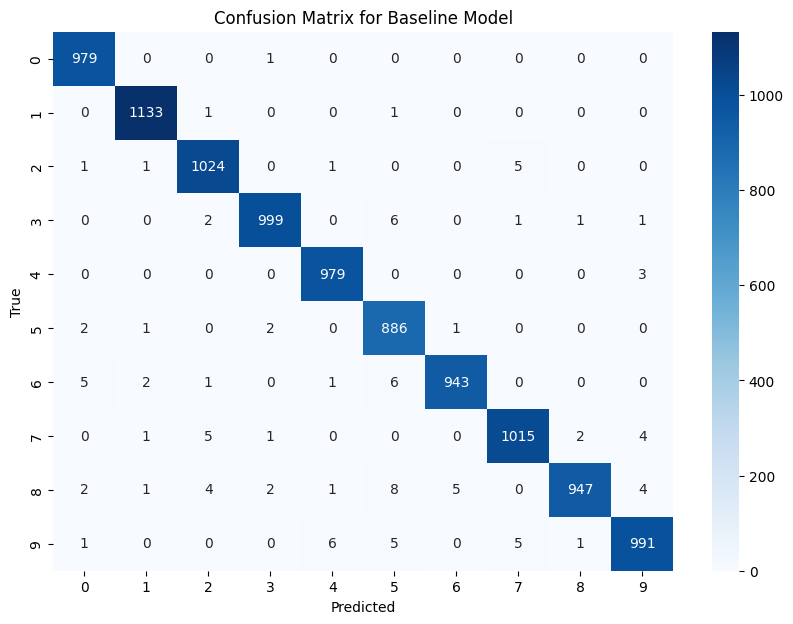

In [32]:
def evaluate_baseline_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Baseline Model Accuracy: {acc*100:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Baseline Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_baseline_model(baseline_model, test_loader, device)


**Train the OSR model:**

In [33]:
osr_model = OSRModel()
optimizer_osr = optim.Adam(osr_model.parameters(), lr=0.001)
criterion_osr = nn.CrossEntropyLoss()
if is_training:
  train_model(osr_model, train_loader, val_loader, criterion_osr, optimizer_osr, num_epochs, device)
   # Save the trained model
  torch.save(osr_model.state_dict(), 'osr_model.pth')
else:
  # Load the saved model weights for evaluation
  osr_model.load_state_dict(torch.load('osr_model.pth'))

Epoch [1/3], Loss: 0.1542
Validation Loss: 0.0520, Accuracy: 98.47%
Epoch [2/3], Loss: 0.0444
Validation Loss: 0.0523, Accuracy: 98.44%
Epoch [3/3], Loss: 0.0309
Validation Loss: 0.0377, Accuracy: 98.91%


***  Open Set Recognition (OSR) approach:***

   Utilizing a convolutional neural network (CNN) specifically designed to handle both in-distribution (known) and out-of-distribution (unknown) data. The model is initially trained on the MNIST dataset, which consists of 10 classes of handwritten digits. To distinguish unknown data, i employ a threshold-based technique on the model's output probabilities, produced by a Softmax layer. During evaluation, i classify samples as 'unknown' if their highest Softmax probability falls below a pre-defined threshold. The MNIST samples are classified as known classes, while samples from the CIFAR10 dataset, treated as out-of-distribution data, are classified as 'unknown' if they don't meet the threshold criteria. This method ensures that the model can effectively recognize and differentiate between known digits and previously unseen OOD samples, thereby addressing the challenge of open set recognition.

**evaluate the preformence of the OSR model on the OOD data, known is mapped to '0' and OOD data maps to '1':**

OOD Binary Classification Accuracy: 96.75%


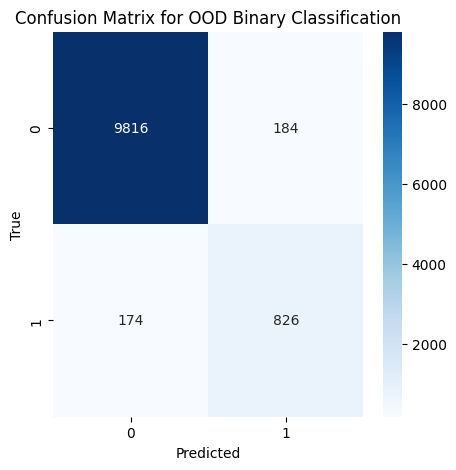

In [34]:
def evaluate_ood_results(model, mnist_loader, ood_loader, device, threshold=0.8):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # Evaluate on MNIST data (should be mapped to 0)
        for data, labels in mnist_loader:
            data = data.to(device)
            outputs = model(data)
            softmax_outputs = F.softmax(outputs, dim=1)
            max_probas, predicted = torch.max(softmax_outputs, dim=1)
            predicted[max_probas < threshold] = 10  # Classify as unknown if below threshold

            mapped_preds = (predicted == 10).long()  # Map to 1 for 'Unknown'
            all_preds.extend(mapped_preds.cpu().numpy())
            all_labels.extend(np.zeros(len(labels)))  # All MNIST data should be 'Known', i.e., 0

        # Evaluate on OOD data (should be mapped to 1)
        for data, _ in ood_loader:
            data = data.to(device)
            outputs = model(data)
            softmax_outputs = F.softmax(outputs, dim=1)
            max_probas, predicted = torch.max(softmax_outputs, dim=1)
            predicted[max_probas < threshold] = 10  # Classify as unknown if below threshold

            mapped_preds = (predicted == 10).long()  # Map to 1 for 'Unknown'
            all_preds.extend(mapped_preds.cpu().numpy())
            all_labels.extend(np.ones(len(data)))  # All OOD data should be 'Unknown', i.e., 1

    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'OOD Binary Classification Accuracy: {acc*100:.2f}%')

    # Binary Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for OOD Binary Classification')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Use the eval function
evaluate_ood_results(osr_model, test_loader, ood_loader, device, threshold=0.8)


**evaluate the preformence of the OSR model on the combined dataset, and plot a confusion matrix for all data. label "10" is marked for the unknown data.**

Total Accuracy on OSR: 96.43%


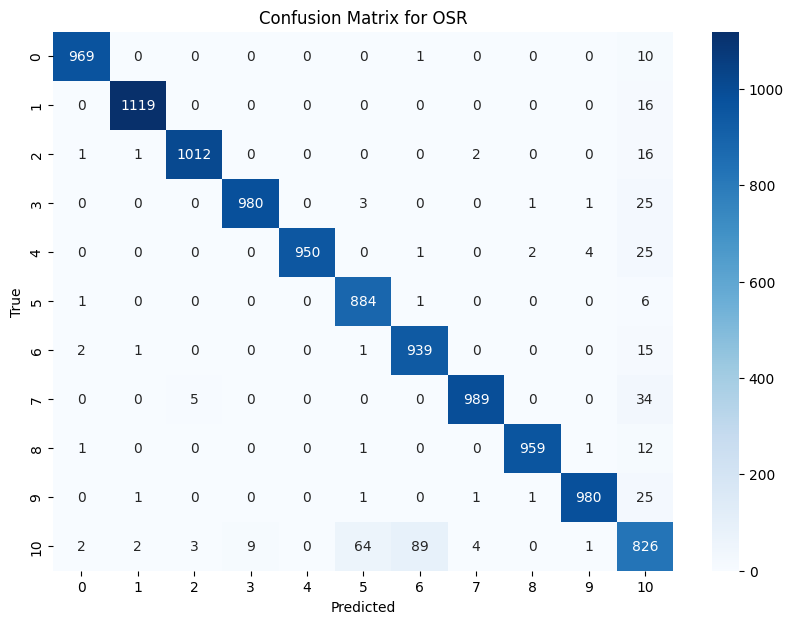

In [35]:
def evaluate_osr_results(model, data_loader, device, threshold=0.8):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            softmax_outputs = F.softmax(outputs, dim=1)
            max_probas, predicted = torch.max(softmax_outputs, dim=1)
            predicted[max_probas < threshold] = 10  # Classify as unknown if below threshold

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Total Accuracy on OSR: {acc*100:.2f}%')

    # 11-class Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for OSR')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_osr_results(osr_model, DataLoader(CombinedDataset(mnist_test, ood_subset), batch_size=batch_size, shuffle=True), device, threshold=0.8)
